# Ports Notebook

The objective of this analysis is to examine the impact of the Red Sea Conflict on maritime trade statistics derived from AIS data.  

We process transit calls and estimated trade volume from the IMF's [PortWatch](https://portwatch.imf.org/) platform for key ports of interest. We then produce charts to inspect trends and calculate percentage changes from a historical baseline.

## Setup

Import libraries and define output paths to save graphs and tables.

In [1]:
import os
import sys
from os.path import join, exists

import pandas as pd
import geopandas as gpd

import git
import time

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red-sea-monitoring"))
from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format, percent_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

## Data

### Ports

In [2]:
# ports = get_ports()
countries = ["Egypt", "Yemen", "Djibouti", "Jordan", "Saudi Arabia"]
# ports_sel = ports.loc[ports.country.isin(countries)].copy()
# ports_sel.sort_values("country", inplace=True)
# ports_sel.loc[:, "geometry"] = ports_sel.apply(lambda x: Point(x.lon, x.lat), axis=1)
# ports_gdf = gpd.GeoDataFrame(ports_sel, geometry="geometry", crs="EPSG:4326")
# ports_gdf.to_file(join(git_root, "data", "ports_sel.geojson"), driver='GeoJSON'))
ports_red_sea = gpd.read_file(
    join(git_root, "data", "red_sea_ports.geojson"), driver="GeoJSON"
)

In [3]:
ports_red_sea[["country", "portname", "portid"]]

,country,portname,portid
0,Djibouti,Djibouti,port294
1,Egypt,El-Adabiya,port321
2,Egypt,Safaga,port191
3,Egypt,North Ain Sukhna Port,port828
4,Egypt,As Suways,port71
5,Jordan,Al Aqabah,port19
6,Saudi Arabia,Duba Bulk Plant Tanker Terminal,port305
7,Saudi Arabia,Rabigh,port1081
8,Saudi Arabia,King Fahd Port,port570
9,Saudi Arabia,Duba,port304


### Map of Ports

In [4]:
ports_red_sea[
    [
        "geometry",
        "portname",
        "country",
        "vessel_count_total",
        "vessel_count_container",
        "vessel_count_dry_bulk",
        "vessel_count_general_cargo",
        "vessel_count_RoRo",
        "vessel_count_tanker",
        "industry_top1",
        "industry_top2",
        "industry_top3",
        "share_country_maritime_import",
        "share_country_maritime_export",
    ]
].explore(
    column="country",
    cmap="Dark2",
    marker_kwds={"radius": 7},
    tiles="Esri.WorldGrayCanvas",
    legend_kwds={"loc": "upper right", "caption": "Ports"},
    # attribution = 'chec'
)

### Trade Data

Pull trade data for selected locations.

In [5]:
ports = list(ports_red_sea.portid)
df_ports = get_port_data(ports)
df_ports.to_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'ports_data_{time.strftime("%Y_%m_%d")}.csv',
    ),
    index=False,
)

## Data Analysis

### Convert to Weekly

In [7]:
df = pd.read_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'ports_data_{time.strftime("%Y_%m_%d")}.csv',
    )
)
df.date = pd.to_datetime(df.date)
df = df.loc[df.date >= "2019-01-01"].copy()

In [8]:
df.tail(2)

,date,year,month,day,portid,portname,country,ISO3,portcalls_cargo,portcalls_tanker,portcalls,import_cargo,export_cargo,import_tanker,export_tanker,import,export,ObjectId
30334,2024-03-08 19:00:00,2024,3,9,port9,Aden,Yemen,YEM,1,1,2,8586.354497,0.0,5269.182384,0.0,13855.536881,0.0,2427506
30335,2024-03-09 19:00:00,2024,3,10,port9,Aden,Yemen,YEM,0,0,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2427507


Calculate weekly sums.

In [9]:
df = df[
    [
        "portname",
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
        "date",
    ]
].copy()
df_raw = df.copy()

df = (
    df.groupby("portname")[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("W-Mon", on="date")
    .sum()
    .reset_index()
)

df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "w"] = df.date.dt.strftime("%W")

In [10]:
df.head(2)

,portname,date,portcalls_cargo,portcalls_tanker,portcalls,import_cargo,export_cargo,import_tanker,export_tanker,import,export,ymd,w
0,Aden,2019-01-07,9,1,10,67364.559011,371.408892,0.0,0.0,67364.559011,371.408892,2019-01-07,01
1,Aden,2019-01-14,9,0,9,37879.939218,0.000000,0.0,0.0,37879.939218,0.000000,2019-01-14,02


### Plot Weekly Trade Volume

In [11]:
# start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [12]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()

In [13]:
charts_by_port_dir = join(charts_dir, "ports")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

In [14]:
start_reference_date = "2022-01-01"
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "w"])[
    [
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)
df_filt = df_filt.merge(df_ref, on=["portname", "w"], how="left", validate="m:1")

In [15]:
for port in df_filt.portname.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portname == port].iloc[0]
    country = port_info.country
    port_id = port_info.portid
    country = ports_red_sea.loc[ports_red_sea.portname == port, "country"].values[0]
    df_port = df_filt.loc[df_filt.portname == port].copy()
    df_port_copy = df_port.copy()
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p0 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )  #  fill="lightblue"
        # + geom_line(aes(x="date", y="export"), alpha=1, color="darkred")
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="#00BFC4", size=1, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="#F8766D", size=1, alpha=3 / 4
        )
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="Metric Tons",
            title=f"Weekly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(text=element_text(family="Roboto"))
        + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
        # + scale_fill_brewer(type='qual', palette=1)
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + theme(legend_position="bottom")
    )
    # display(p0)
    p0.save(
        filename=join(charts_by_port_dir, f"estimated-trade-{port_id}.jpeg"), dpi=300
    )

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports\estimated-trade-port9.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports\estimated-trade-port18.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: Plotnine

### Resample to Monthly

In [16]:
df = (
    df_raw.groupby("portname")[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("MS", on="date")
    .sum()
    .reset_index()
)
df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "m"] = df.date.dt.strftime("%m")

In [17]:
df.head(2)

,portname,date,portcalls_cargo,portcalls_tanker,portcalls,import_cargo,export_cargo,import_tanker,export_tanker,import,export,ymd,m
0,Aden,2019-01-01,35,7,42,211348.052875,1848.225266,61496.118007,3160.095388,272844.170882,5008.320654,2019-01-01,01
1,Aden,2019-02-01,43,5,48,306744.763449,10160.227084,42407.618684,6320.190776,349152.382132,16480.417860,2019-02-01,02


### Calculate Reference Values

Periods
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

In [18]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [19]:
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = (
    df_ref.groupby(["portname", "m"])[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
        ]
    ]
    .mean()
    .reset_index()
)
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)

Filter recent data (2023 onwards) and merge reference values.

In [20]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["portname", "m"], how="left", validate="m:1")

In [21]:
charts_by_port_dir = join(charts_dir, "ports-ref-monthly")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

### Plot Monthly Trade Volume and Historical Average

In [23]:
for port in df_filt.portname.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portname == port].iloc[0]
    country = port_info.country
    port_id = port_info.portid
    country = ports_red_sea.loc[ports_red_sea.portname == port, "country"].values[0]
    df_port = df_filt.loc[df_filt.portname == port].copy()
    df_port_copy = df_port.copy()
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p1 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )  #  fill="lightblue"
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="#00BFC4", size=1, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="#F8766D", size=1, alpha=3 / 4
        )
        # + geom_line(aes(x="date", y="export"), alpha=1, color="darkred")
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="Metric Tons",
            title=f"Monthly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(text=element_text(family="Roboto"))
        + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
        # + scale_fill_brewer(type='qual', palette=1)
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + theme(legend_position="bottom")
    )
    # display(p0)
    p1.save(
        filename=join(charts_by_port_dir, f"estimated-trade-{port_id}.jpeg"), dpi=300
    )

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports-ref-monthly\estimated-trade-port9.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports-ref-monthly\estimated-trade-port18.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\sm

## Summary Statistics

Calculate average values by port and time period.

In [24]:
conflict_date, crisis_date

('2023-10-07', '2023-11-17')

In [25]:
df.loc[:, "period"] = ""
df.loc[(df.date >= start_reference_date) & (df.date < crisis_date), "period"] = (
    "Reference"
)
df.loc[(df.date >= conflict_date) & (df.date < crisis_date), "period"] = (
    "Middle East Conflict"
)
df.loc[(df.date >= crisis_date), "period"] = "Red Sea Crisis"
df = df.merge(ports_red_sea[["portname", "country"]], on="portname")

In [38]:
df_agg = (
    df.loc[df.period != ""]
    .groupby(["country", "portname", "period"])[
        [
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
        ]
    ]
    .mean()
)

# change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=2
)

In [40]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

### Table: Monthly Average Values by Time Period

In [41]:
table = df_agg.copy()
table = table.applymap(lambda x: "{:,.0f}".format(x))
table.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
table.index.names = ["Country", "Port", "Period"]
table

C:\Users\WB514197\AppData\Local\Temp\ipykernel_28960\528398492.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Djibouti     Djibouti                        Reference                 496,308   
                                             Middle East Conflict      508,484   
                                             Red Sea Crisis            384,636   
Egypt        As Suways                       Reference                   5,323   
                                             Middle East Conflict        5,706   
                                             Red Sea Crisis              7,381   
             El-Adabiya                      Reference                  56,300   
                                             Middle East Conflict       63,403   
                                             Red Sea Crisis             22,053   
             North Ain Sukhna Port           Reference                 417,759   
                                             Middle East Conflict      478,392   
                                             Red Sea Crisis            266,075   
             Safaga                          Reference                  73,389   
                                             Middle East Conflict       87,906   
                                             Red Sea Crisis             94,155   
Jordan       Al Aqabah                       Reference                 505,924   
                                             Middle East Conflict      323,583   
                                             Red Sea Crisis            210,940   
Saudi Arabia Duba                            Reference                  11,470   
                                             Middle East Conflict        9,502   
                                             Red Sea Crisis             14,450   
             Duba Bulk Plant Tanker Terminal Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             Jiddah                          Reference               1,115,921   
                                             Middle East Conflict    1,247,488   
                                             Red Sea Crisis            651,185   
             Jiddah Oil                      Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             King Fahd Port                  Reference                  72,768   
                                             Middle East Conflict       44,789   
                                             Red Sea Crisis             64,949   
             Rabigh                          Reference                 516,192   
                                             Middle East Conflict      443,722   
                                             Red Sea Crisis            167,878   
             Yanbu                           Reference                 127,704   
                                             Middle East Conflict       89,140   
                                             Red Sea Crisis             95,902   
Yemen        Aden                            Reference                 216,989   
                                             Middle East Conflict      163,033   
                                             Red Sea Crisis            124,287   
             Al Ahmadi                       Reference                 135,216   
                                             Middle East Conflict      231,536   
                                             Red Sea Crisis            204,261   
             Al Mukalla                      Reference                  18,541   
                                             Middle East Conflict       17,786   
                                             Red

In [42]:
countries = list(df.country.unique())
df_agg_copy = df_agg.copy()
res = []
for country in countries:
    df_country = df_agg_copy.loc[(country), :].copy()
    aois = df_country.index.get_level_values(0).unique()
    for aoi in aois:
        df_sub = df_country.loc[(aoi), :].transpose().copy()
        df_sub.loc[:, "Middle East Conflict"] = (
            df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub.loc[:, "Red Sea Crisis"] = (
            df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub2 = df_sub.transpose()
        df_sub2.drop("Reference", inplace=True)
        df_sub2.loc[:, "portname"] = aoi
        df_sub2.loc[:, "country"] = country
        res.append(df_sub2)

In [43]:
df_agg_pct = pd.concat(res)
table2 = df_agg_pct.copy()

### Table: Monthly Average Values by Time Period, % Change from Baseline

In [44]:
table2.reset_index(inplace=True)
table2.set_index(["country", "portname", "period"], inplace=True)

# format columns as pct
table2 = table2.applymap(lambda x: "{:.2%}".format(x))
table2.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
table2.index.names = ["Country", "Port", "Period"]
table2

C:\Users\WB514197\AppData\Local\Temp\ipykernel_28960\1744506812.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -24.87%   
                                             Red Sea Crisis            -42.72%   
             Al Ahmadi                       Middle East Conflict       71.23%   
                                             Red Sea Crisis             51.06%   
             Al Mukalla                      Middle East Conflict       -4.07%   
                                             Red Sea Crisis            -62.25%   
Jordan       Al Aqabah                       Middle East Conflict      -36.04%   
                                             Red Sea Crisis            -58.31%   
Egypt        As Suways                       Middle East Conflict        7.20%   
                                             Red Sea Crisis             38.66%   
             El-Adabiya                      Middle East Conflict       12.62%   
                                             Red Sea Crisis            -60.83%   
             North Ain Sukhna Port           Middle East Conflict       14.51%   
                                             Red Sea Crisis            -36.31%   
             Safaga                          Middle East Conflict       19.78%   
                                             Red Sea Crisis             28.30%   
Djibouti     Djibouti                        Middle East Conflict        2.45%   
                                             Red Sea Crisis            -22.50%   
Saudi Arabia Duba                            Middle East Conflict      -17.15%   
                                             Red Sea Crisis             25.98%   
             Duba Bulk Plant Tanker Terminal Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             Jiddah                          Middle East Conflict       11.79%   
                                             Red Sea Crisis            -41.65%   
             Jiddah Oil                      Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             King Fahd Port                  Middle East Conflict      -38.45%   
                                             Red Sea Crisis            -10.75%   
             Rabigh                          Middle East Conflict      -14.04%   
                                             Red Sea Crisis            -67.48%   
             Yanbu                           Middle East Conflict      -30.20%   
                                             Red Sea Crisis            -24.90%   

                                                                  Cargo Export  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -67.76%   
                                             Red Sea Crisis            -76.83%   
             Al Ahmadi                       Middle East Conflict      -23.33%   
                                             Red Sea Crisis            -71.15%   
             Al Mukalla                      Middle East Conflict      -84.15%   
                                             Red Sea Crisis            -91.88%   
Jordan       Al Aqabah                       Middle East Conflict      -51.47%   
                                             Red Sea Crisis            -51.19%   
Egypt        As Suways                       Middle East Conflict     -100.00%   
                                             Red Sea Crisis            -43.41%   
             El-Adabiya                      Middle East Conflict       39.15%   
                                             Red Sea Crisis            -29.33%   
             North Ain Sukhna Port           Middle East Conflict      124.15%   
                                             Re

## Parade Chart: Absolute Differences

In [45]:
countries = list(df.country.unique())
df_agg_copy = df_agg.copy()
res = []
for country in countries:
    df_country = df_agg_copy.loc[(country), :].copy()
    aois = df_country.index.get_level_values(0).unique()
    for aoi in aois:
        df_sub = df_country.loc[(aoi), :].transpose().copy()
        df_sub.loc[:, "Middle East Conflict"] = (
            df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
        )
        df_sub.loc[:, "Red Sea Crisis"] = (
            df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
        )
        df_sub2 = df_sub.transpose()
        df_sub2.drop("Reference", inplace=True)
        df_sub2.loc[:, "portname"] = aoi
        df_sub2.loc[:, "country"] = country
        res.append(df_sub2)
df_agg_diff = pd.concat(res)

In [46]:
df_agg_diff = df_agg_diff.reset_index()
df_agg_diff = df_agg_diff.loc[df_agg_diff.period == "Red Sea Crisis"].copy()

df_agg_diff.loc[:, "import_direction"] = df_agg_diff["import"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)
df_agg_diff.loc[:, "export_direction"] = df_agg_diff["export"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)

df_agg_diff.loc[:, "import_absolute"] = df_agg_diff["import"].apply(lambda x: abs(x))
df_agg_diff.loc[:, "export_absolute"] = df_agg_diff["export"].apply(lambda x: abs(x))

df_agg_diff.sort_values("import_absolute", ascending=False, inplace=True)
df_agg_diff["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

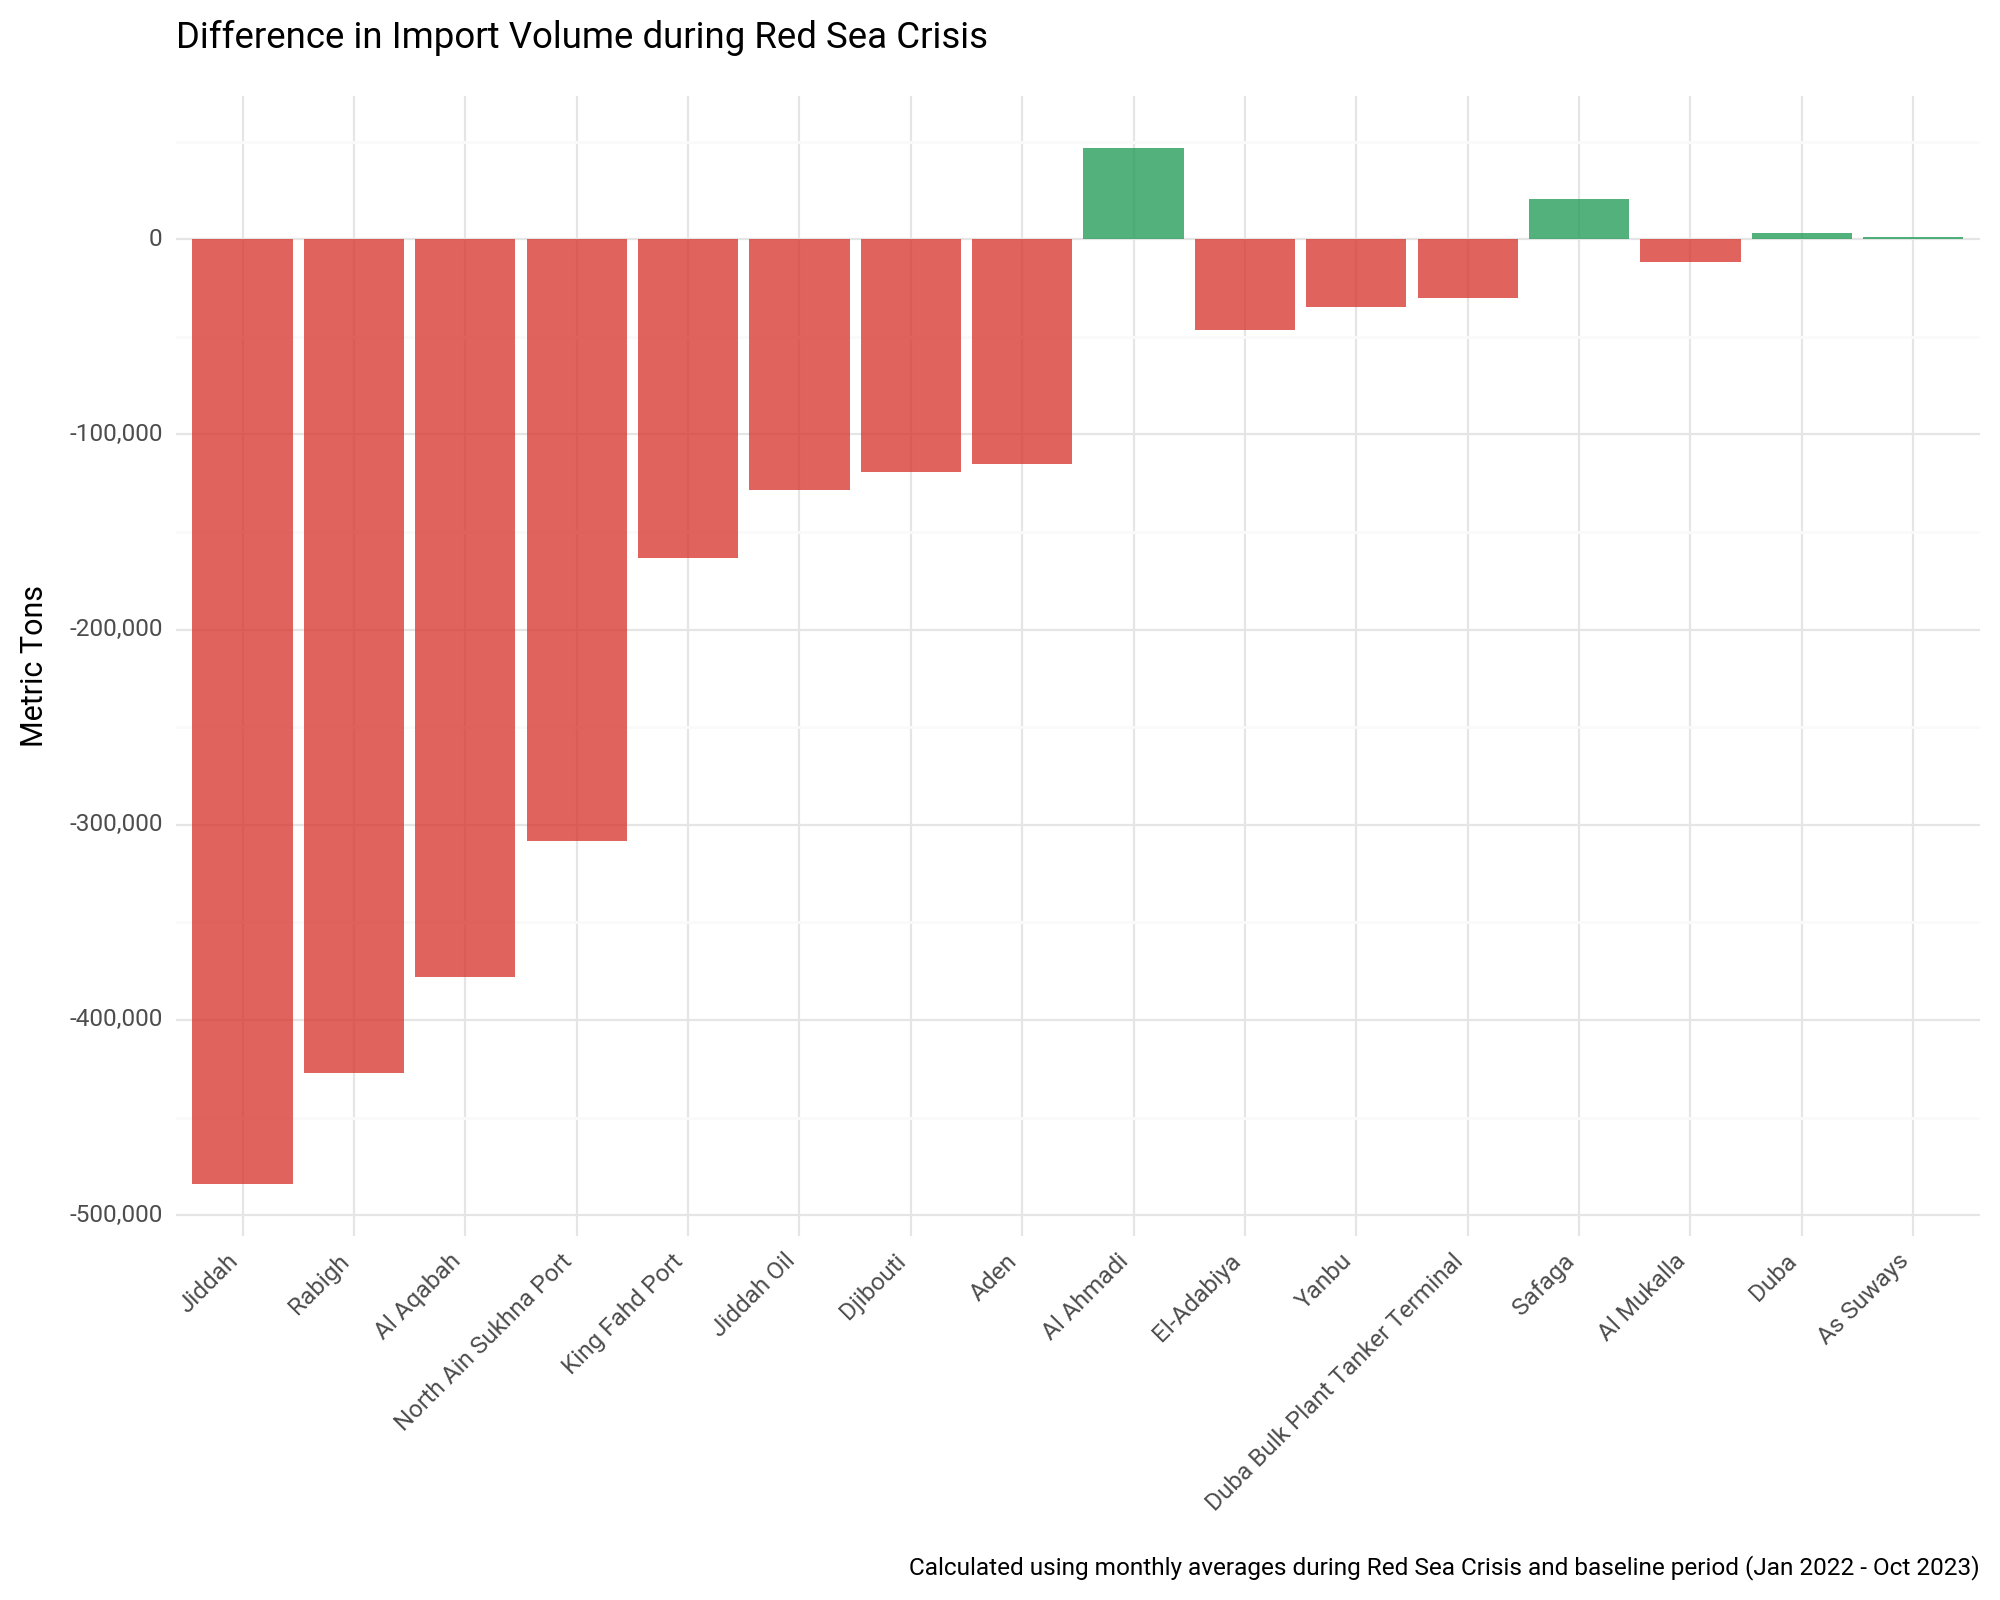

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\import-difference.jpeg


In [47]:
p2 = (
    ggplot(df_agg_diff, aes(x="portname_cat", y="import", fill="import_direction"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Metric Tons",
        title="Difference in Import Volume during Red Sea Crisis",
        caption="Calculated using monthly averages during Red Sea Crisis and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p2)
p2.save(filename=join(charts_dir, "import-difference.jpeg"), dpi=300)

In [48]:
df_agg_diff.sort_values("export_absolute", ascending=False, inplace=True)
df_agg_diff["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

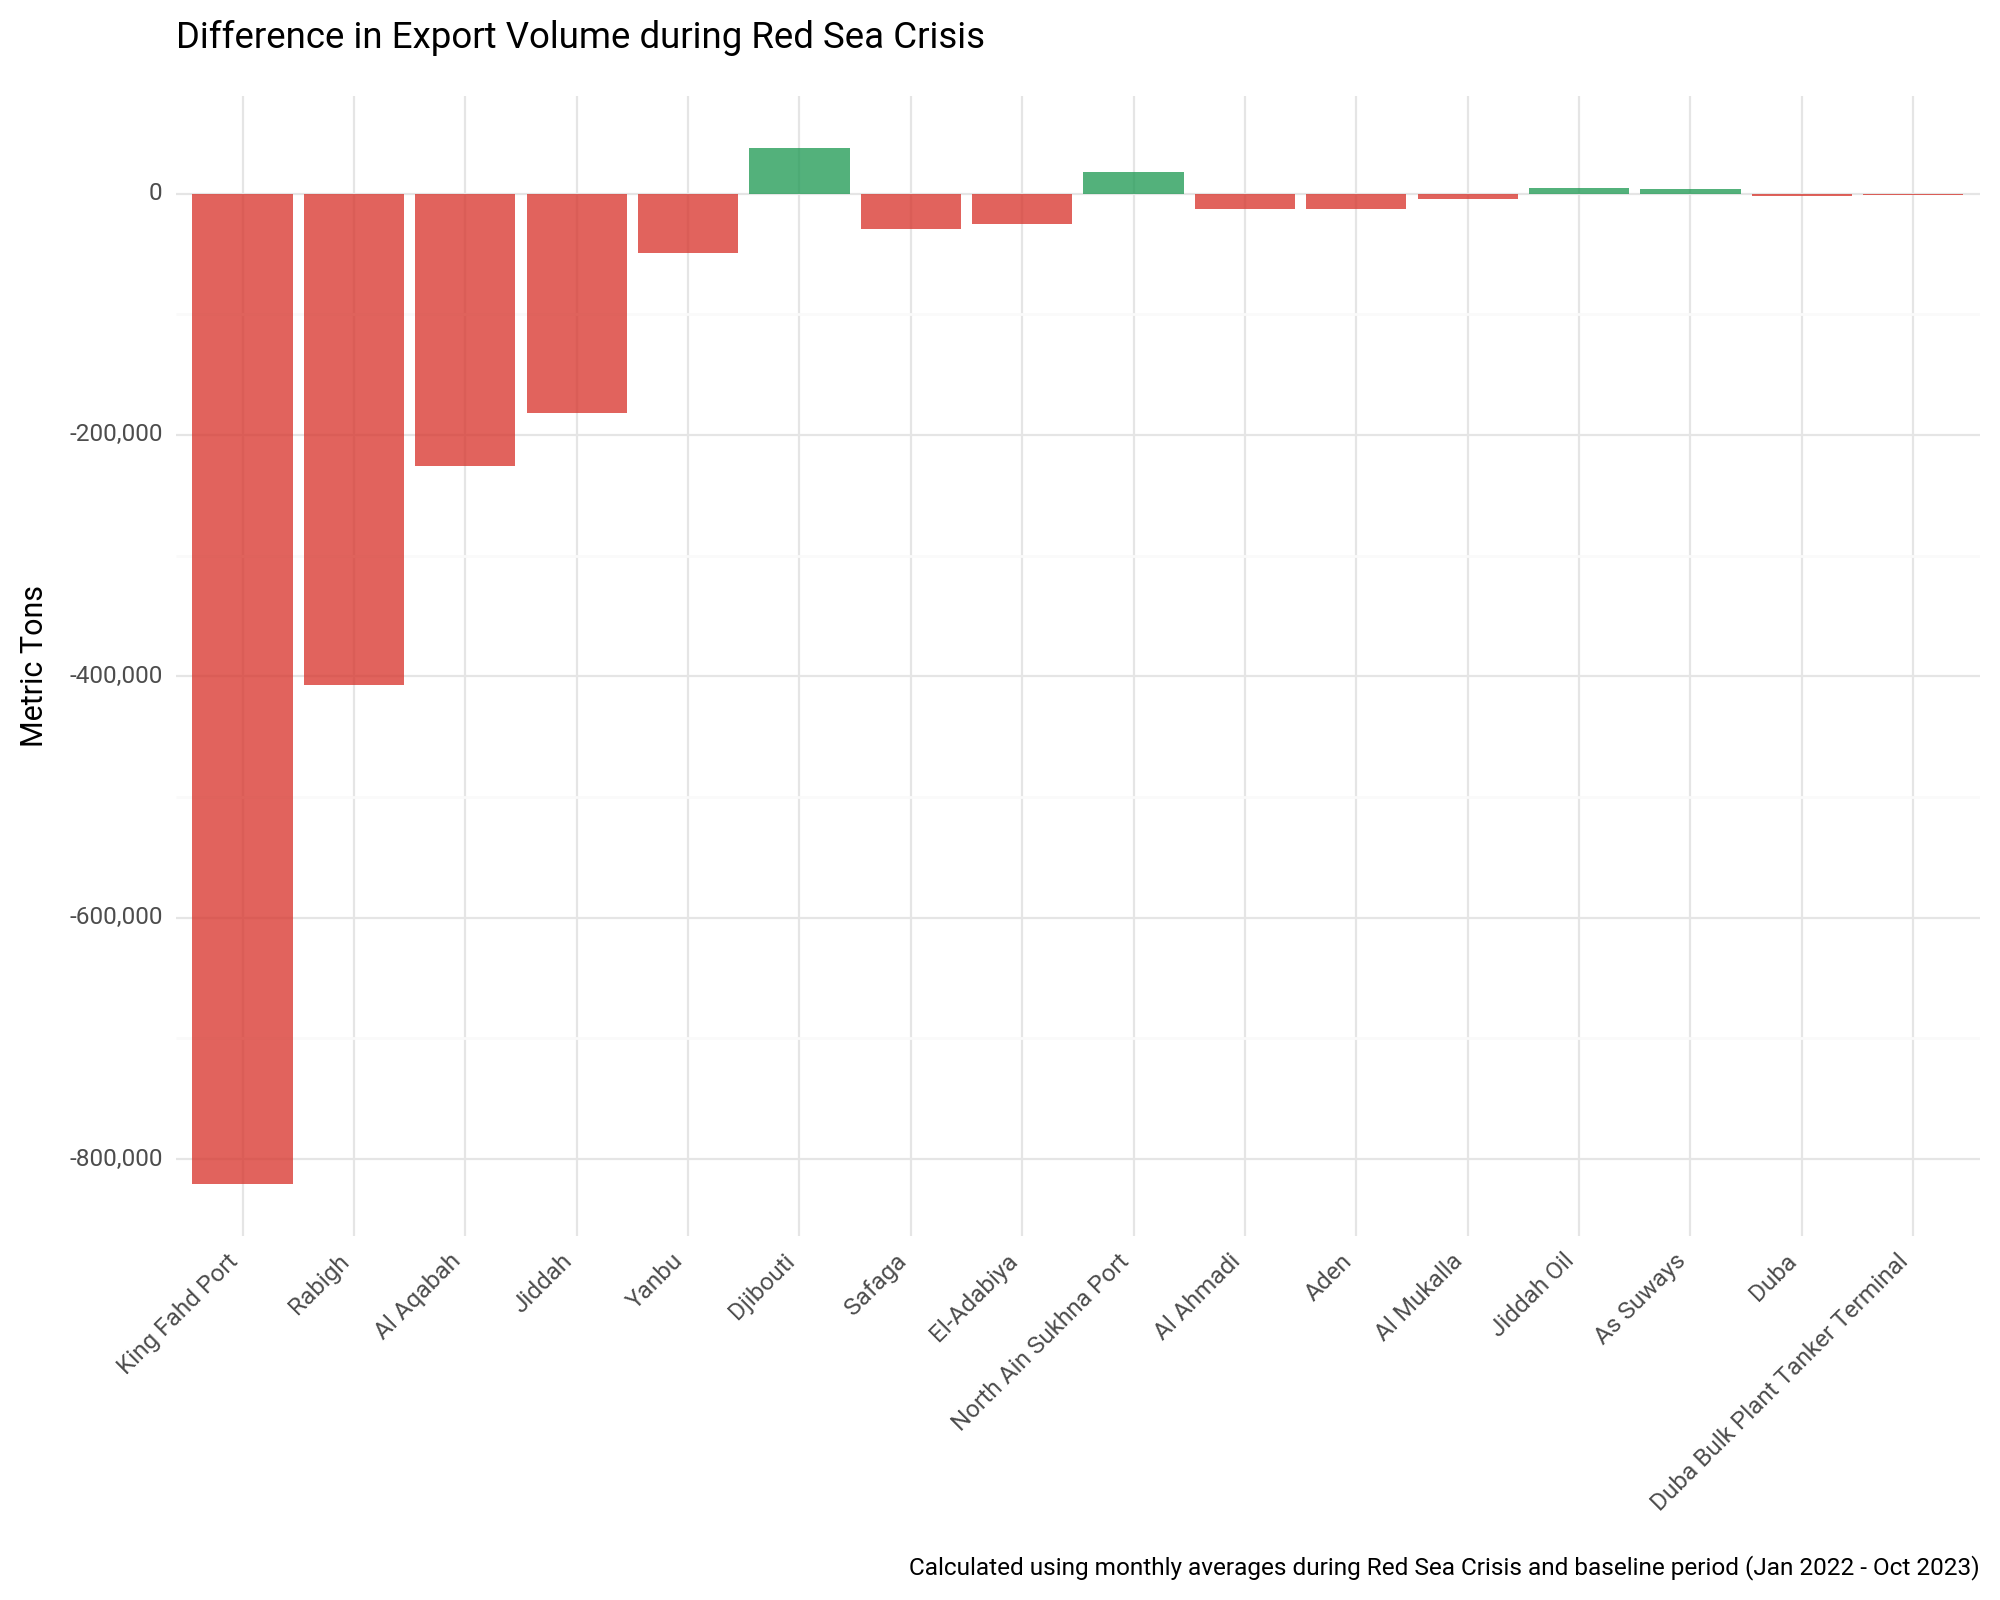

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\export-difference.jpeg


In [49]:
p2 = (
    ggplot(df_agg_diff, aes(x="portname_cat", y="export", fill="export_direction"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="Metric Tons",
        title="Difference in Export Volume during Red Sea Crisis",
        caption="Calculated using monthly averages during Red Sea Crisis and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + scale_fill_distiller(type="div", palette="RdYlGn", direction=1)
    # + scale_fill_brewer(type='div', palette='RdYlGn')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p2)
p2.save(filename=join(charts_dir, "export-difference.jpeg"), dpi=300)

## Parade Chart % Diff

In [51]:
df_agg_pct_raw = df_agg_pct.reset_index()
df_agg_pct_raw = df_agg_pct_raw.loc[df_agg_pct_raw.period == "Red Sea Crisis"].copy()

df_agg_pct_raw.loc[:, "import_direction"] = df_agg_pct_raw["import"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)
df_agg_pct_raw.loc[:, "export_direction"] = df_agg_pct_raw["export"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)

df_agg_pct_raw.loc[:, "import_absolute"] = df_agg_pct_raw["import"].apply(
    lambda x: abs(x)
)
df_agg_pct_raw.loc[:, "export_absolute"] = df_agg_pct_raw["export"].apply(
    lambda x: abs(x)
)

df_agg_pct_raw.sort_values("import_absolute", ascending=False, inplace=True)
df_agg_pct_raw["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

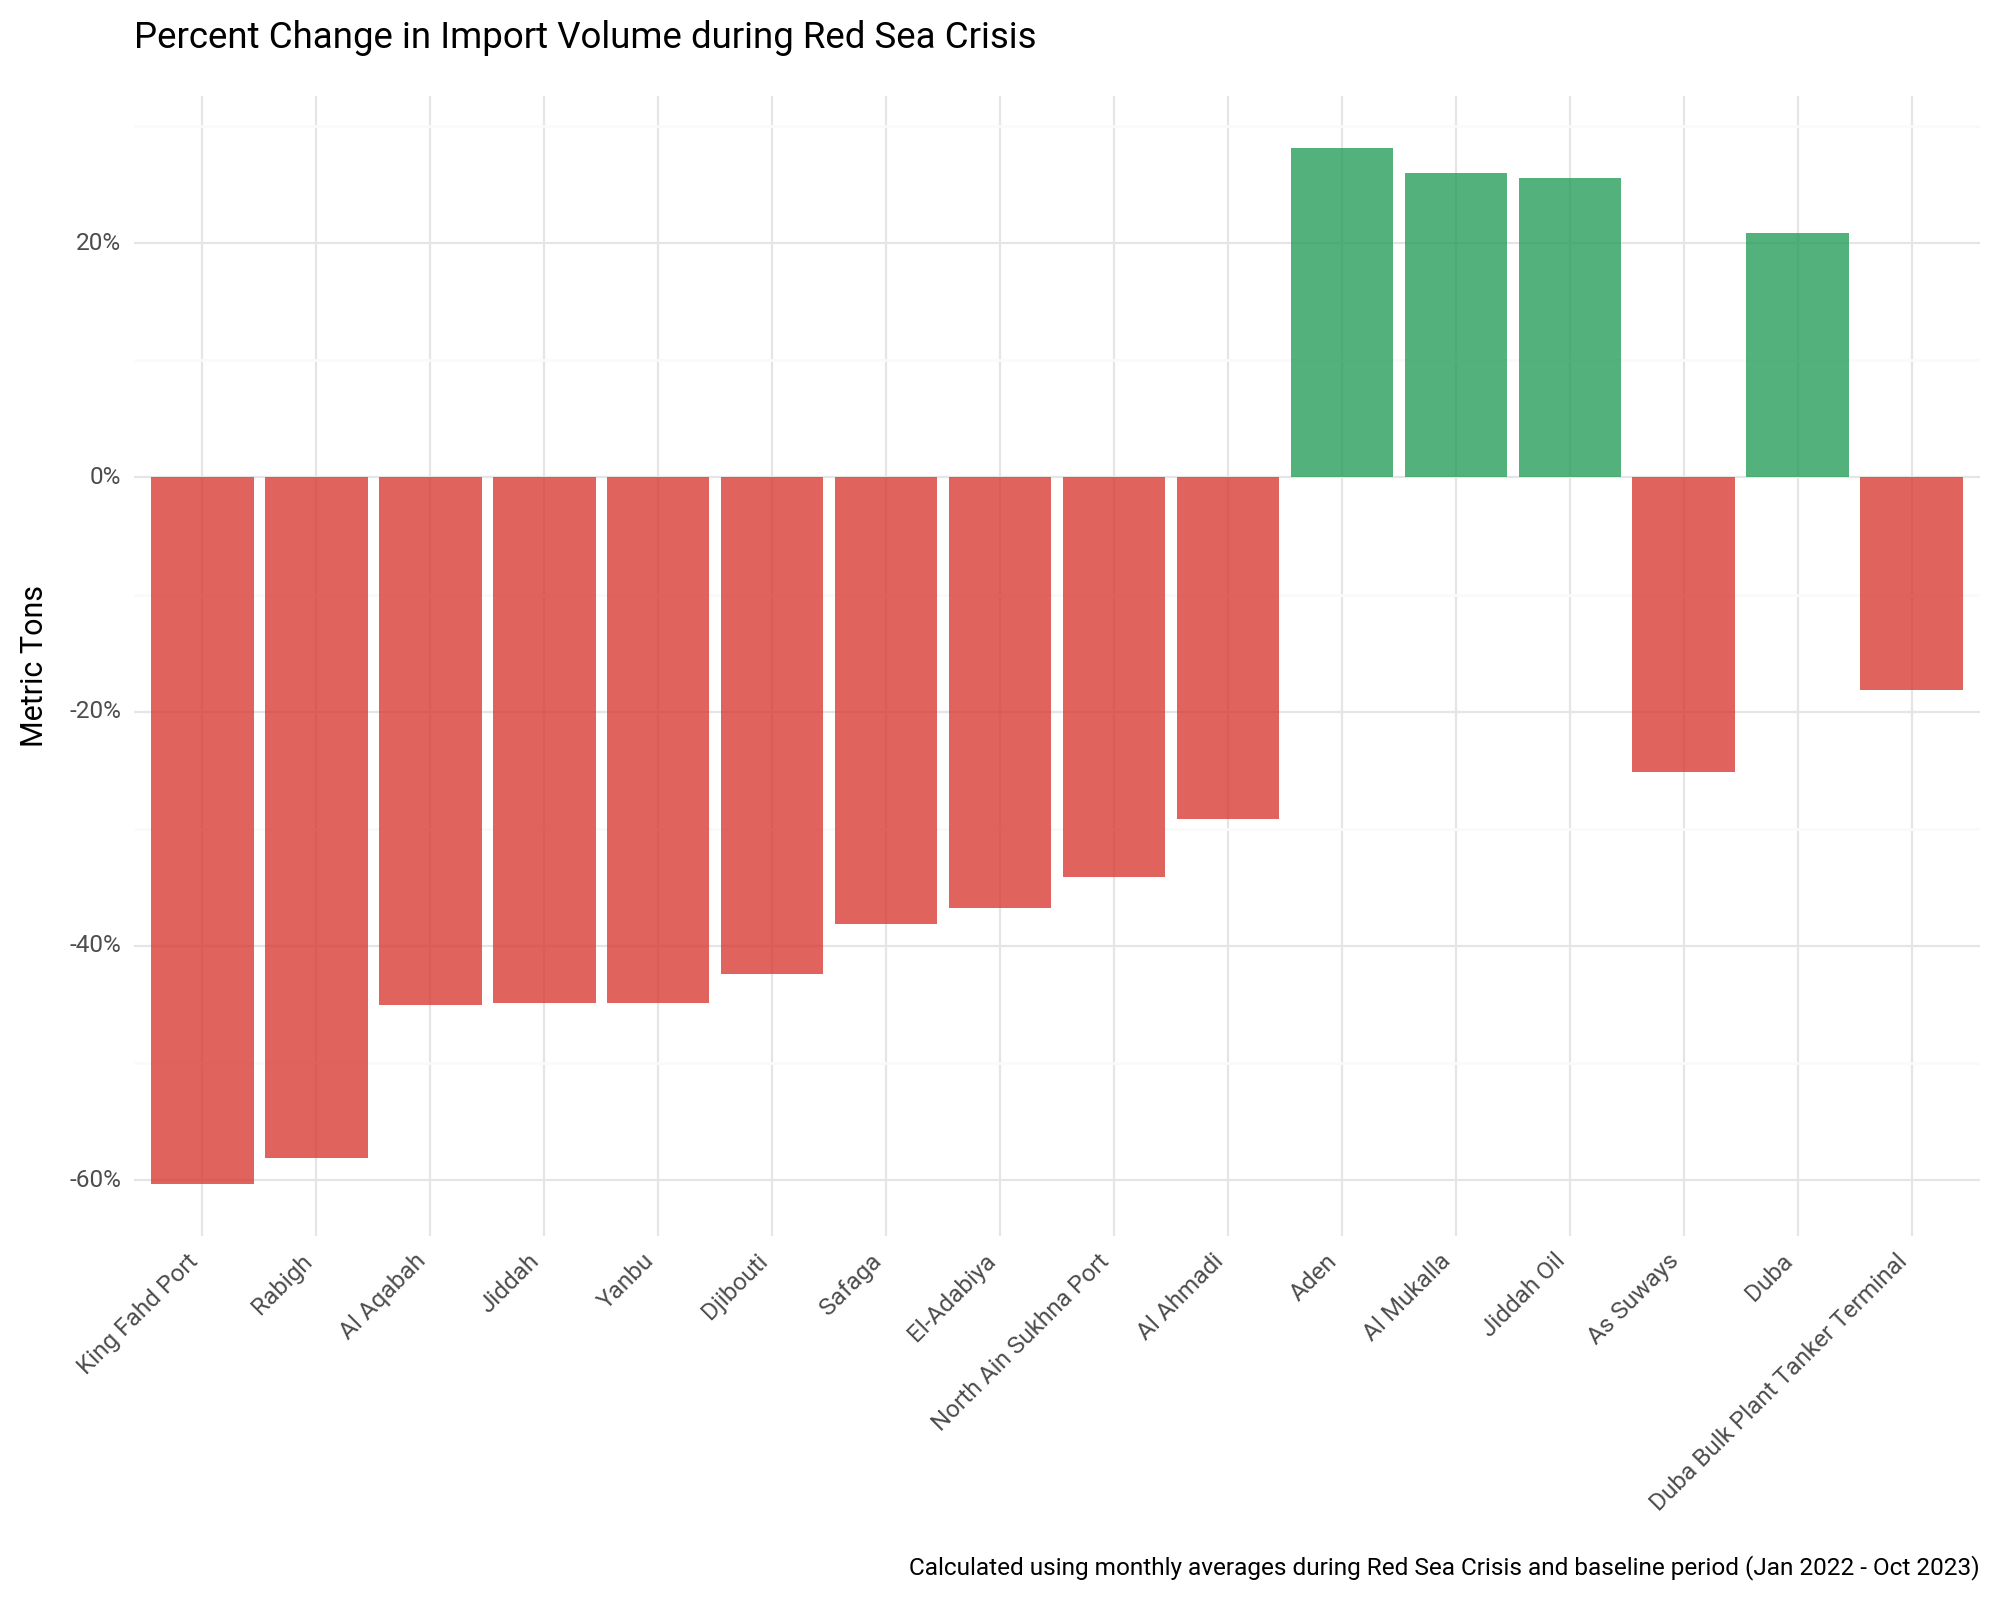

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\import-pct-change.jpeg


In [53]:
p1 = (
    ggplot(
        df_agg_pct_raw, aes(x="portname_cat", y="import", fill="import_direction")
    )  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="Metric Tons",
        title="Percent Change in Import Volume during Red Sea Crisis",
        caption="Calculated using monthly averages during Red Sea Crisis and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=percent_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + scale_fill_distiller(type="div", palette="RdYlGn", direction=1)
    # + scale_fill_brewer(type='div', palette='RdYlGn')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p1)
p1.save(filename=join(charts_dir, "import-pct-change.jpeg"), dpi=300)

In [54]:
df_agg_pct_raw.sort_values("export_absolute", ascending=False, inplace=True)
df_agg_pct_raw["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

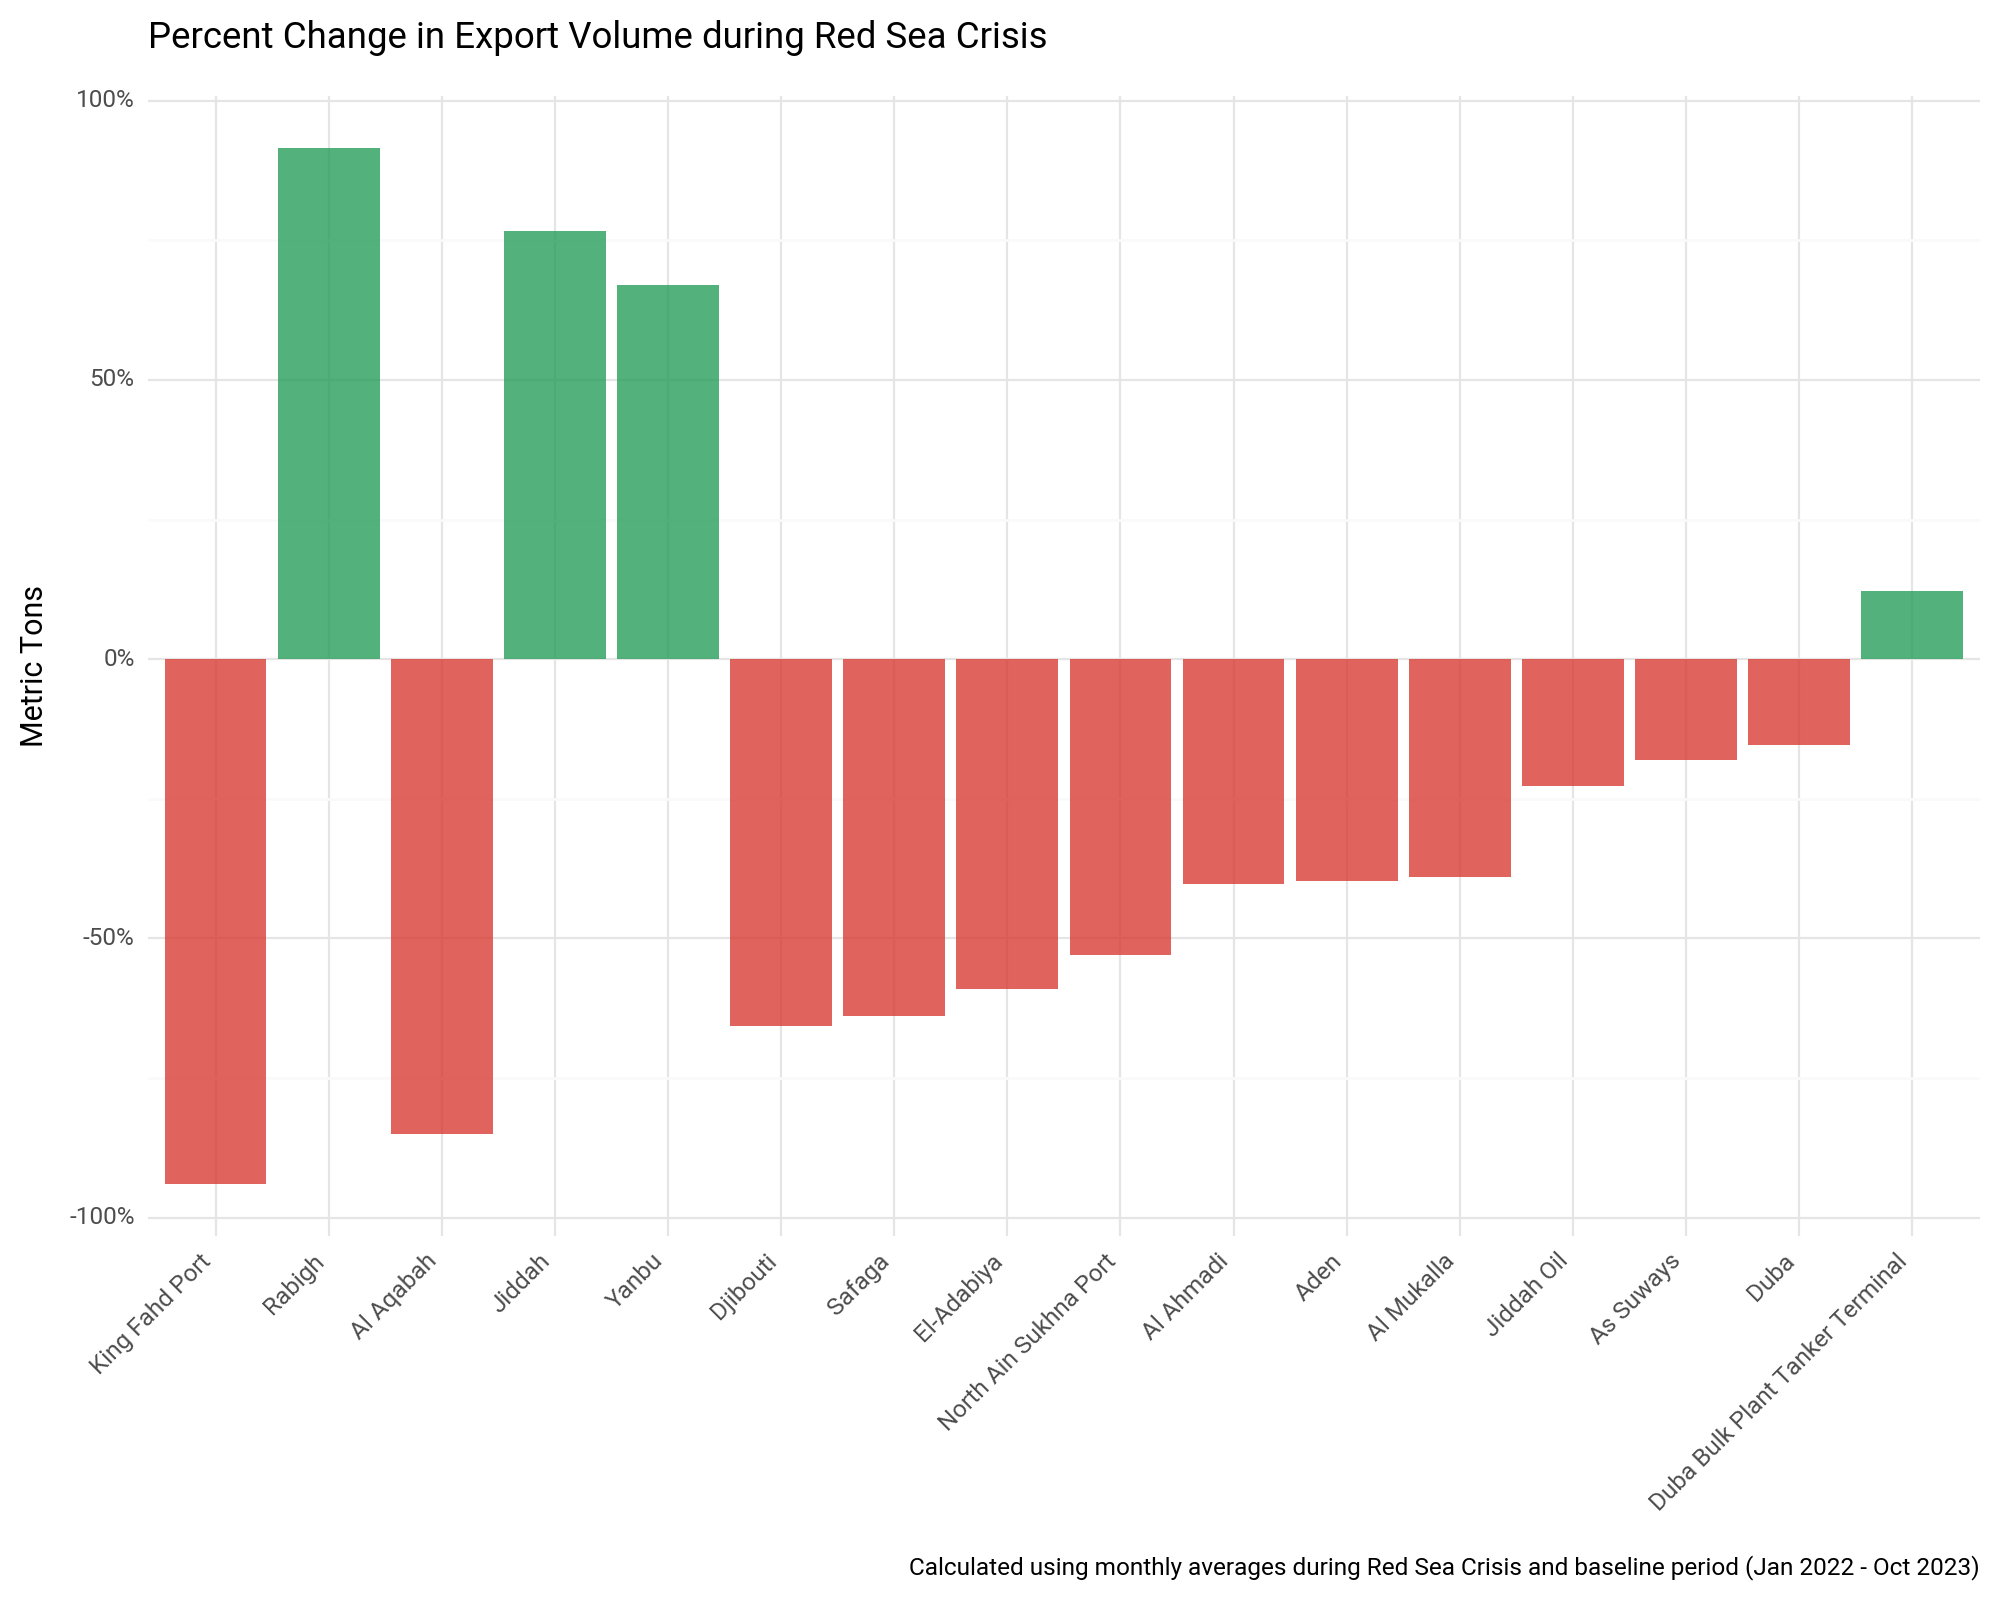

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\export-pct-change.jpeg


In [55]:
p2 = (
    ggplot(
        df_agg_pct_raw, aes(x="portname_cat", y="export", fill="export_direction")
    )  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="Metric Tons",
        title="Percent Change in Export Volume during Red Sea Crisis",
        caption="Calculated using monthly averages during Red Sea Crisis and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=percent_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + scale_fill_distiller(type="div", palette="RdYlGn", direction=1)
    # + scale_fill_brewer(type='div', palette='RdYlGn')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p2)
p2.save(filename=join(charts_dir, "export-pct-change.jpeg"), dpi=300)

Save tables with and without formatting

In [56]:
df_agg = df_agg.reset_index()
df_agg_pct = df_agg_pct.reset_index()

df_agg_pct = df_agg_pct[
    [
        "country",
        "portname",
        "period",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
]

In [57]:
df_agg.rename(
    columns={
        "country": "Country",
        "portname": "Port",
        "period": "Period",
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
df_agg_pct.rename(
    columns={
        "country": "Country",
        "portname": "Port",
        "period": "Period",
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)

In [58]:
with pd.ExcelWriter(
    join(output_dir, "tables", f'summary-tables-ports-{time.strftime("%Y_%m_%d")}.xlsx')
) as writer:
    table.to_excel(writer, sheet_name="Ports Summary")
    table2.to_excel(writer, sheet_name="Ports % Change")
    df_agg.to_excel(writer, sheet_name="Ports Summary (Raw)")
    df_agg_pct.to_excel(writer, sheet_name="Ports % Change (Raw)")